# A first approach to parareal
Strongly based in https://en.wikipedia.org/wiki/Parareal

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Set the problem

In [14]:
## Dynamics
def dydt(y, t):
    return 1/(1.05 + np.sin(t))

## Initial condition
y0 = 1

## Simulation times
t0 = 0
tend = 25
ts_coarse = np.linspace(t0, tend, 6)
ts = np.linspace(t0, tend, 61) # Used just for graphics

## Calculate numerical solution
For future reference. We will consider this THE solution

In [15]:
sol = odeint(dydt, y0, ts)

## Show me the playground

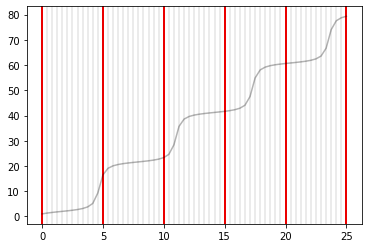

In [16]:
def plotpartition(ts, ts_coarse):
    for i in range(0, ts_coarse.size):
        plt.axvline(ts_coarse[i], linewidth = 2, color = 'red')
    
    for i in range(0, ts.size):
        plt.axvline(ts[i], alpha = 0.1, color = 'black')        

    
plotpartition(ts, ts_coarse)
plt.plot(ts, sol, color = 'black', alpha = 0.3)
plt.show()

In [17]:
# Solvers
def G(y0, t0, t):
    ''' Coarse integrator
    
    Directly from the 1700s, just a brutal Euler method
    '''
    return y0 + dydt(y0, t) * (t - t0)

def heun(y0, t0, t):
    ''' Heun's integration method
    
    Another old timer, also known as Euler's improved method
    '''
    ytemp = G(y0, t0, t)
    return y0 + (t -t0)/2 * (dydt(y0, t0) + dydt(ytemp, t))

def F(y0, t0, t, nSubSteps = 10):
    ''' Fine integrator
    
    Just uses Heun's method over a grid nSubSteps times finer
    '''
    ts = np.linspace(t0, t, nSubSteps)
    
    ys = np.empty(nSubSteps)
    ys[0] = y0
    for i in range(1, nSubSteps):
        ys[i] = heun(ys[i-1], ts[i-1], ts[i])
        
    return ys[-1]

def updater(fun, y0, ts):
    nSteps = ts.size
    ys = np.empty(nSteps)
    ys[0] = y0
    
    for i in range(1, nSteps):
        ys[i] = fun(ys[i-1], ts[i-1], ts[i])
        
    return ys

## Set up the parareal scheme

In [18]:
K = 6 # Number of iterations
Y = np.ones((ts_coarse.size, K))*y0

## First iteration

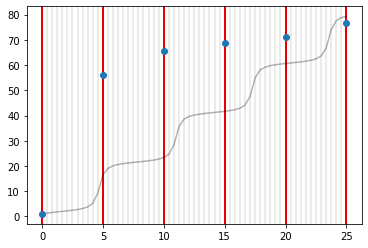

In [19]:
Y[:, 0] = updater(G, y0, ts_coarse)

plotpartition(ts, ts_coarse)
plt.plot(ts, sol, color = 'black', alpha = 0.3)
plt.plot(ts_coarse, Y[:, 0], 'o')
plt.show()

## Main loop
Here we populate $Y$

In [20]:
for j in range(0, ts_coarse.size-1):
    for k in range(0, K-1):
        Y[j+1, k+1] = F(Y[j, k], ts_coarse[j], ts_coarse[j+1], nSubSteps = 10) \
                    + G(Y[j, k+1], ts_coarse[j], ts_coarse[j+1]) \
                    - G(Y[j, k], ts_coarse[j], ts_coarse[j+1])

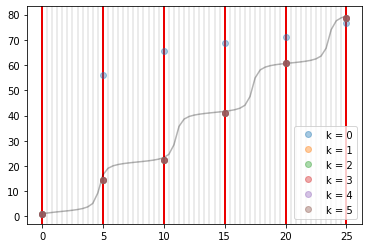

In [21]:
plotpartition(ts, ts_coarse)
plt.plot(ts, sol, color = 'black', alpha = 0.3)
for k in range(0, K):
    plt.plot(ts_coarse, Y[:, k], 'o', alpha = 0.4, label = 'k = %s' % k)
plt.legend()
plt.show()